In [77]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import DataFrame
from typing import List

%matplotlib inline

### Анализ данных

Загрузим датасет и проверим его на пропуски в данных

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  7060 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Два признака в которых есть пропуски - это Item_Weight и Outlet_Sze, вес товара и размер магазина соответственно.

Пропуски нужно как-то заполнить. Есть предположение, что вес товаров в одной категории должен быть примерно одинаковым. Проверим это предположение.

In [5]:
# всего 16 категорий
df.Item_Type.unique().shape

(16,)

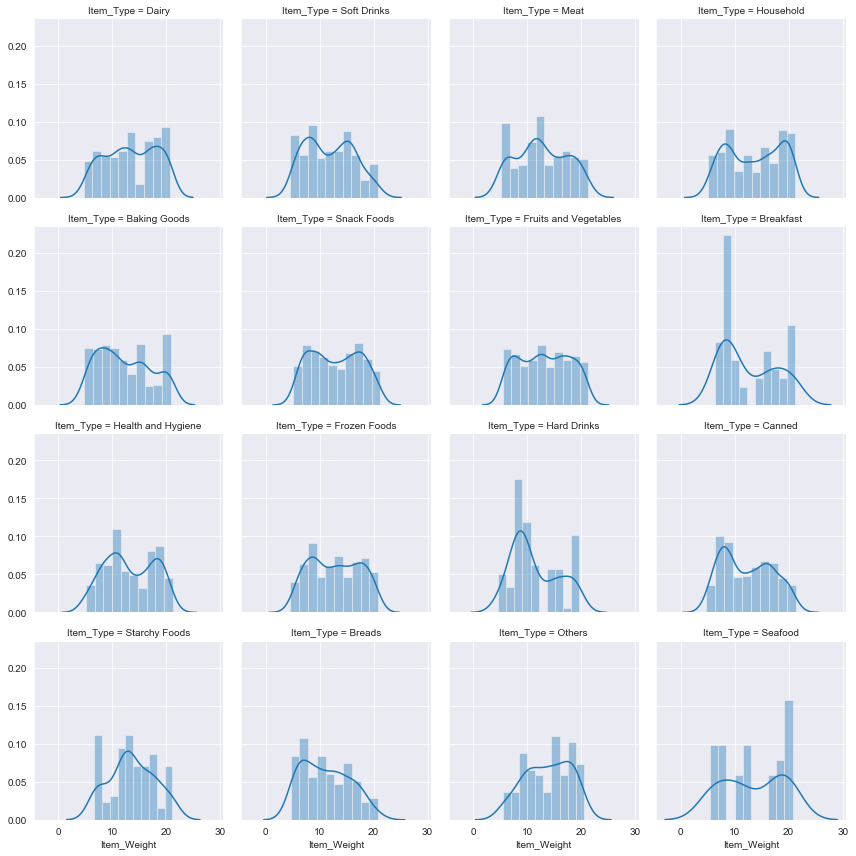

In [6]:
# визуализируем распределние веса товаров с помощью гистограммы
sns.set_style('darkgrid')
df_plot = df.dropna()

g = sns.FacetGrid(df_plot, col='Item_Type', col_wrap=4)
g.map(sns.distplot, 'Item_Weight', bins=10)
plt.show()

На графиках не получилось заметить нормальное распределение веса, для большинства категорий распределние веса товаров скорее равномерное.

В датасете указанны данные о продажах. Один и тот же товар может быть в разных магазинах, проверим сколько в датасете уникальных товаров.

In [7]:
# всего 1559 уникальных товаров
df.Item_Identifier.unique().shape

(1559,)

Если данных о весе товара нет у одного магазина, то это не значит, что их нет у другого магазина. Скорее всего можно будет восстановить данные о весе по данным другого магазина об этом товаре.

In [8]:
df[df['Item_Weight'].isnull()].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362


In [17]:
df[df.Item_Identifier == 'FDP10'].head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
585,FDP10,19.0,Low Fat,0.128066,Snack Foods,104.3622,OUT035,2004,Small,Tier 2,Supermarket Type1,1905.5196
2623,FDP10,19.0,Low Fat,0.128815,Snack Foods,107.6622,OUT017,2007,NaN,Tier 2,Supermarket Type1,1164.4842
3382,FDP10,19.0,Low Fat,0.128289,Snack Foods,104.9622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1164.4842
4585,FDP10,19.0,Low Fat,0.128090,Snack Foods,107.0622,OUT046,1997,Small,Tier 1,Supermarket Type1,1376.2086


Предположение подтвердилось, данные о весе можно восстановить по данным из других магазинов. 

Теперь напишем функцию, для заполнения пропущенных полей.

In [83]:
def fill_weight(df: DataFrame) -> List[float]:
    new_weights = []
    for i in df.index:
        if math.isnan(df.loc[i, 'Item_Weight']):
            id = df.loc[i, 'Item_Identifier']
            condition = (df['Item_Identifier'] == id) & df['Item_Weight'].notnull()
            try:
                weight = df[condition]['Item_Weight'].iloc[0]
            except IndexError:
                weight = df.loc[i, 'Item_Weight']
        else:
            weight = df.loc[i, 'Item_Weight']
    
        new_weights.append(weight)
    
    return new_weights

In [84]:
new_weights = fill_weight(df)

df['Item_Weight'] = new_weights

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
Item_Identifier              8523 non-null object
Item_Weight                  8519 non-null float64
Item_Fat_Content             8523 non-null object
Item_Visibility              8523 non-null float64
Item_Type                    8523 non-null object
Item_MRP                     8523 non-null float64
Outlet_Identifier            8523 non-null object
Outlet_Establishment_Year    8523 non-null int64
Outlet_Size                  6113 non-null object
Outlet_Location_Type         8523 non-null object
Outlet_Type                  8523 non-null object
Item_Outlet_Sales            8523 non-null float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


Мы успешно заполнили практически все пропуски.